# Grid Interpolation Validation

As part of porting the CMFGEN models to SNCosmo, the models are interpolated onto a uniform grid. As a simple sanity check, this notebook calculates the residuals between the original, un-interpolated model and the gridded model.

In [1]:
import sys

import sncosmo
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
import sncosmo_models


In [2]:
# Load models for different masses
sncosmo_models.register_sources(force=True)
m102 = sncosmo.get_source('CMFGEN', version=1.02)
m104 = sncosmo.get_source('CMFGEN', version=1.04)
m14 = sncosmo.get_source('CMFGEN', version=1.4)
m17 = sncosmo.get_source('CMFGEN', version=1.7)
models = (m102, m104, m14, m17)


We note that the wavelength range of the interpolated model is sometimes less than the original model. Although this idfference is small (less than an Angstrom), the sncosmo models are not able to model flux outside the interpolated wavelength range. To address this, we specify a `max_wavelength` value.

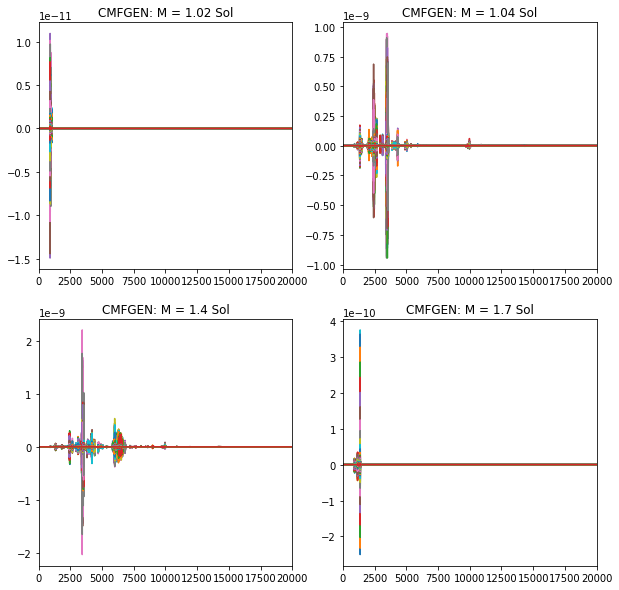

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

max_wavelength = 2e4
for model, axis in zip(models, axes.flatten()):
    phase, wave, flux = model.original_model()
    
    for f, p, w in zip(flux, phase, wave):
        # Only consider data below the specified wavelength range.
        indices = w < max_wavelength
        w = w[indices]
        f = f[indices]
        
        grid_flux = model.flux(p, w)
        residuals = f - grid_flux
        
        axis.plot(w, residuals)
        axis.set_xlim(0, max_wavelength)
        axis.set_title(f'{model.name}: M = {model.version} Sol')
